In [2]:
import sys

print(sys.version)  # 3.6.8

3.6.8 (default, Dec 24 2018, 19:24:27) 
[GCC 5.4.0 20160609]


In [3]:
import tensorflow as tf

tf.enable_eager_execution()

In [4]:
tf.test.is_gpu_available()

True

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm

import numpy as np
import pandas as pd

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score

from pandas.plotting import scatter_matrix

from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

from math import sqrt

from itertools import combinations, combinations_with_replacement

from cycler import cycler

In [7]:
BATCH_SIZE = 8


def _parse_predict_function(example_proto):
    # Create a description of the features.
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        "floorplan": tf.FixedLenFeature(
            [28, 28, 6], tf.float32, default_value=tf.zeros([28, 28, 6], tf.float32)
        ),
        "plan_id": tf.FixedLenFeature([], tf.string, default_value=""),
        "norm_year": tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        "is_area_85": tf.FixedLenFeature([], tf.int64, default_value=0),
        "is_core": tf.FixedLenFeature([], tf.int64, default_value=0),
        "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)

    return (
        parsed_example["floorplan"],
        parsed_example["plan_id"],
        parsed_example["norm_year"],
    )


def create_predict_dataset(filepaths):

    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [8]:
predict_dataset = create_predict_dataset(["/data/fp.tfrecord",])

In [9]:
ids, fps = [], []

iter = predict_dataset.make_one_shot_iterator()
for batch in iter:
    ids.extend(batch[1].numpy())
    fps.extend(batch[0].numpy())

ids = [id.decode() for id in ids]

len(ids), ids[0], len(fps), fps[0].shape

W0128 05:42:29.227209 140694863513344 deprecation.py:323] From <ipython-input-9-2ae9ed37f69b>:3: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(50540, '23112_103F', 50540, (28, 28, 6))

In [10]:
fps_array = np.asarray(fps)
X = fps_array.reshape(50540, 4704)

In [11]:
X.shape

(50540, 4704)

In [12]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5, n_jobs=-1)

In [13]:
neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

In [ ]:
distances, indices = neigh.kneighbors()

In [ ]:
distances

In [ ]:
np.nonzero(distances == 0)[0]  # 누가

In [ ]:
indices[distances == 0]  # 누구랑

In [136]:
channel_to_rgba = np.concatenate(
    (
        [[0.0, 0.0, 0.0, 1.0]],  # unit mask to alpha
        (
            -1.0  # make colors subtractive
            + np.array(
                [
                    [0.0, 0.33, 0.0, 1.0],  # entrance to green L30
                    [1.0, 0.25, 0.0, 1.0],  # LDK to red L57
                    [0.0, 0.26, 1.0, 1.0],  # bedroom to blue L40
                    [0.83, 0.87, 0.0, 1.0],  # balcony to yellow L85
                    [0.0, 0.81, 0.76, 1.0],  # bathroom to cyan L75
                ]
            )
        ),
    )
)

print(channel_to_rgba)
# [[ 0.    0.    0.    1.  ]
#  [-1.   -0.67 -1.    0.  ]
#  [ 0.   -0.75 -1.    0.  ]
#  [-1.   -0.74  0.    0.  ]
#  [-0.17 -0.13 -1.    0.  ]
#  [-1.   -0.19 -0.24  0.  ]]

# put it on transparent white
fps_rgba = np.clip(
    np.array([1.0, 1.0, 1.0, 0.0]) + (np.array(fps) @ channel_to_rgba), 0, 1
)

[[ 0.    0.    0.    1.  ]
 [-1.   -0.67 -1.    0.  ]
 [ 0.   -0.75 -1.    0.  ]
 [-1.   -0.74  0.    0.  ]
 [-0.17 -0.13 -1.    0.  ]
 [-1.   -0.19 -0.24  0.  ]]


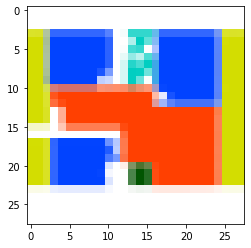

In [137]:
fig = plt.figure()
ax = plt.imshow(fps_rgba[ids.index("9765_107A")])

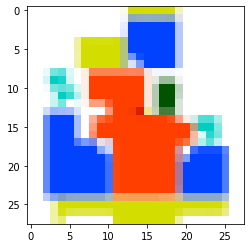

In [139]:
fig = plt.figure()
ax = plt.imshow(fps_rgba[16390])

['2140_92B', '2140_92B', '100528_61A', '12924_97', '18701_87', '104986_111F', '19720_92', '27809_110A', '25120_110B', '8657_77']
['2907_94A', '2140_90A', '100528_58', '8392_97', '18702_87', '104986_111E', '106448_92', '27808_106A', '103705_109B', '8657_86A']


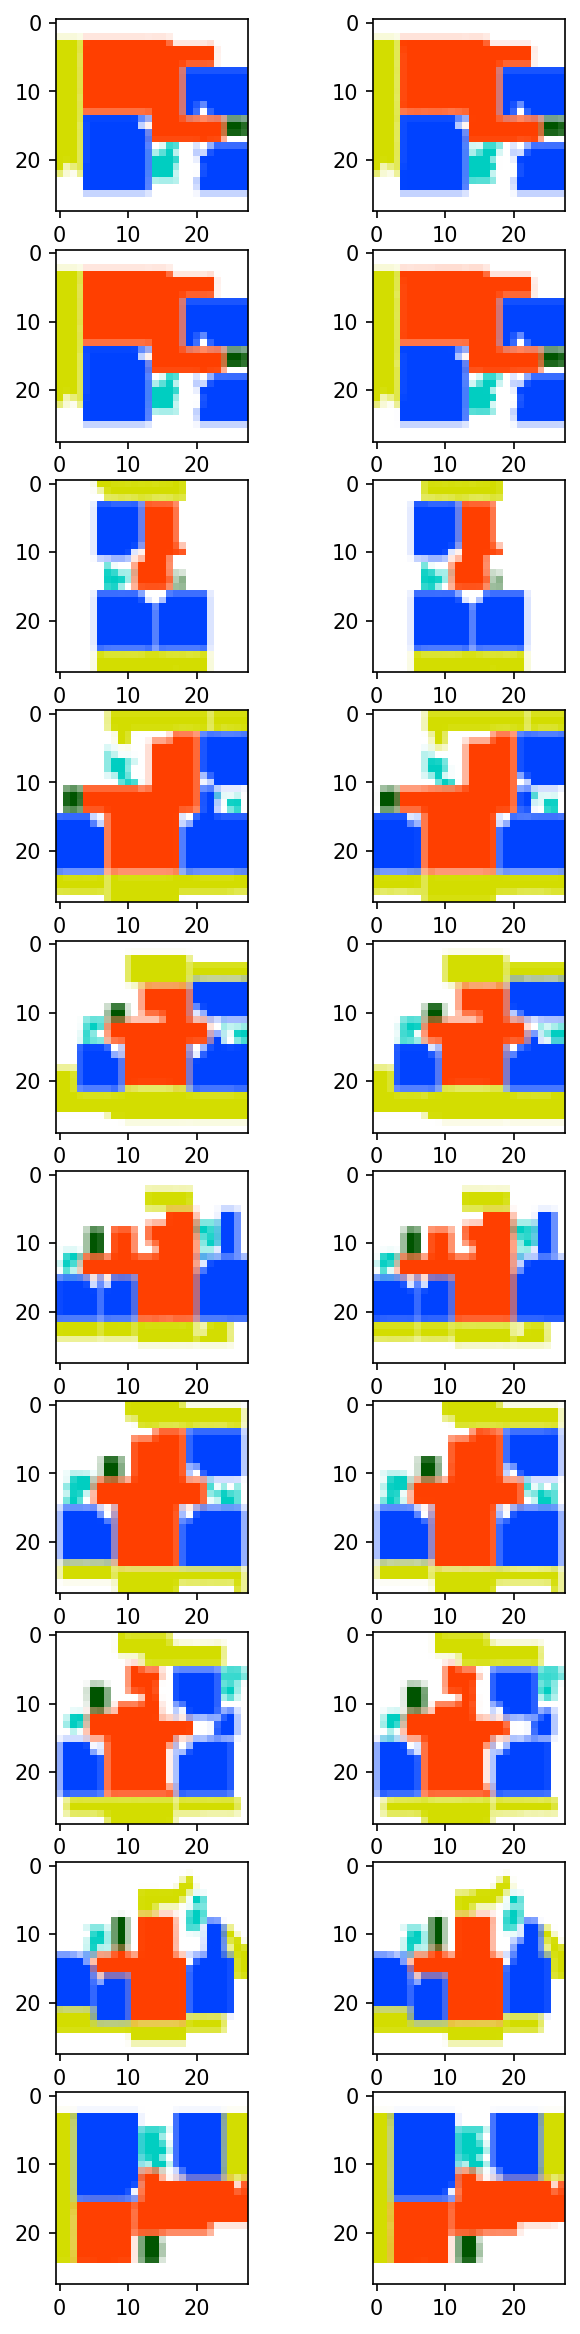

In [233]:
similar = (distances > 1) & (distances < 2)

print([ids[id] for id in np.nonzero(similar)[0][0:10]])  # 누가
print([ids[id] for id in indices[similar][0:10]])  # 누구랑

fig, axes = plt.subplots(10, 2, figsize=(5, 20), dpi=150)

for i in range(10):
    axes[i, 0].imshow(fps_rgba[np.nonzero(similar)[0][i]])
    axes[i, 1].imshow(fps_rgba[indices[similar][i]])

plt.show()

In [142]:
distances[:, 0].shape

(50540,)

In [196]:
np.amin(distances)

0.0

10491 372


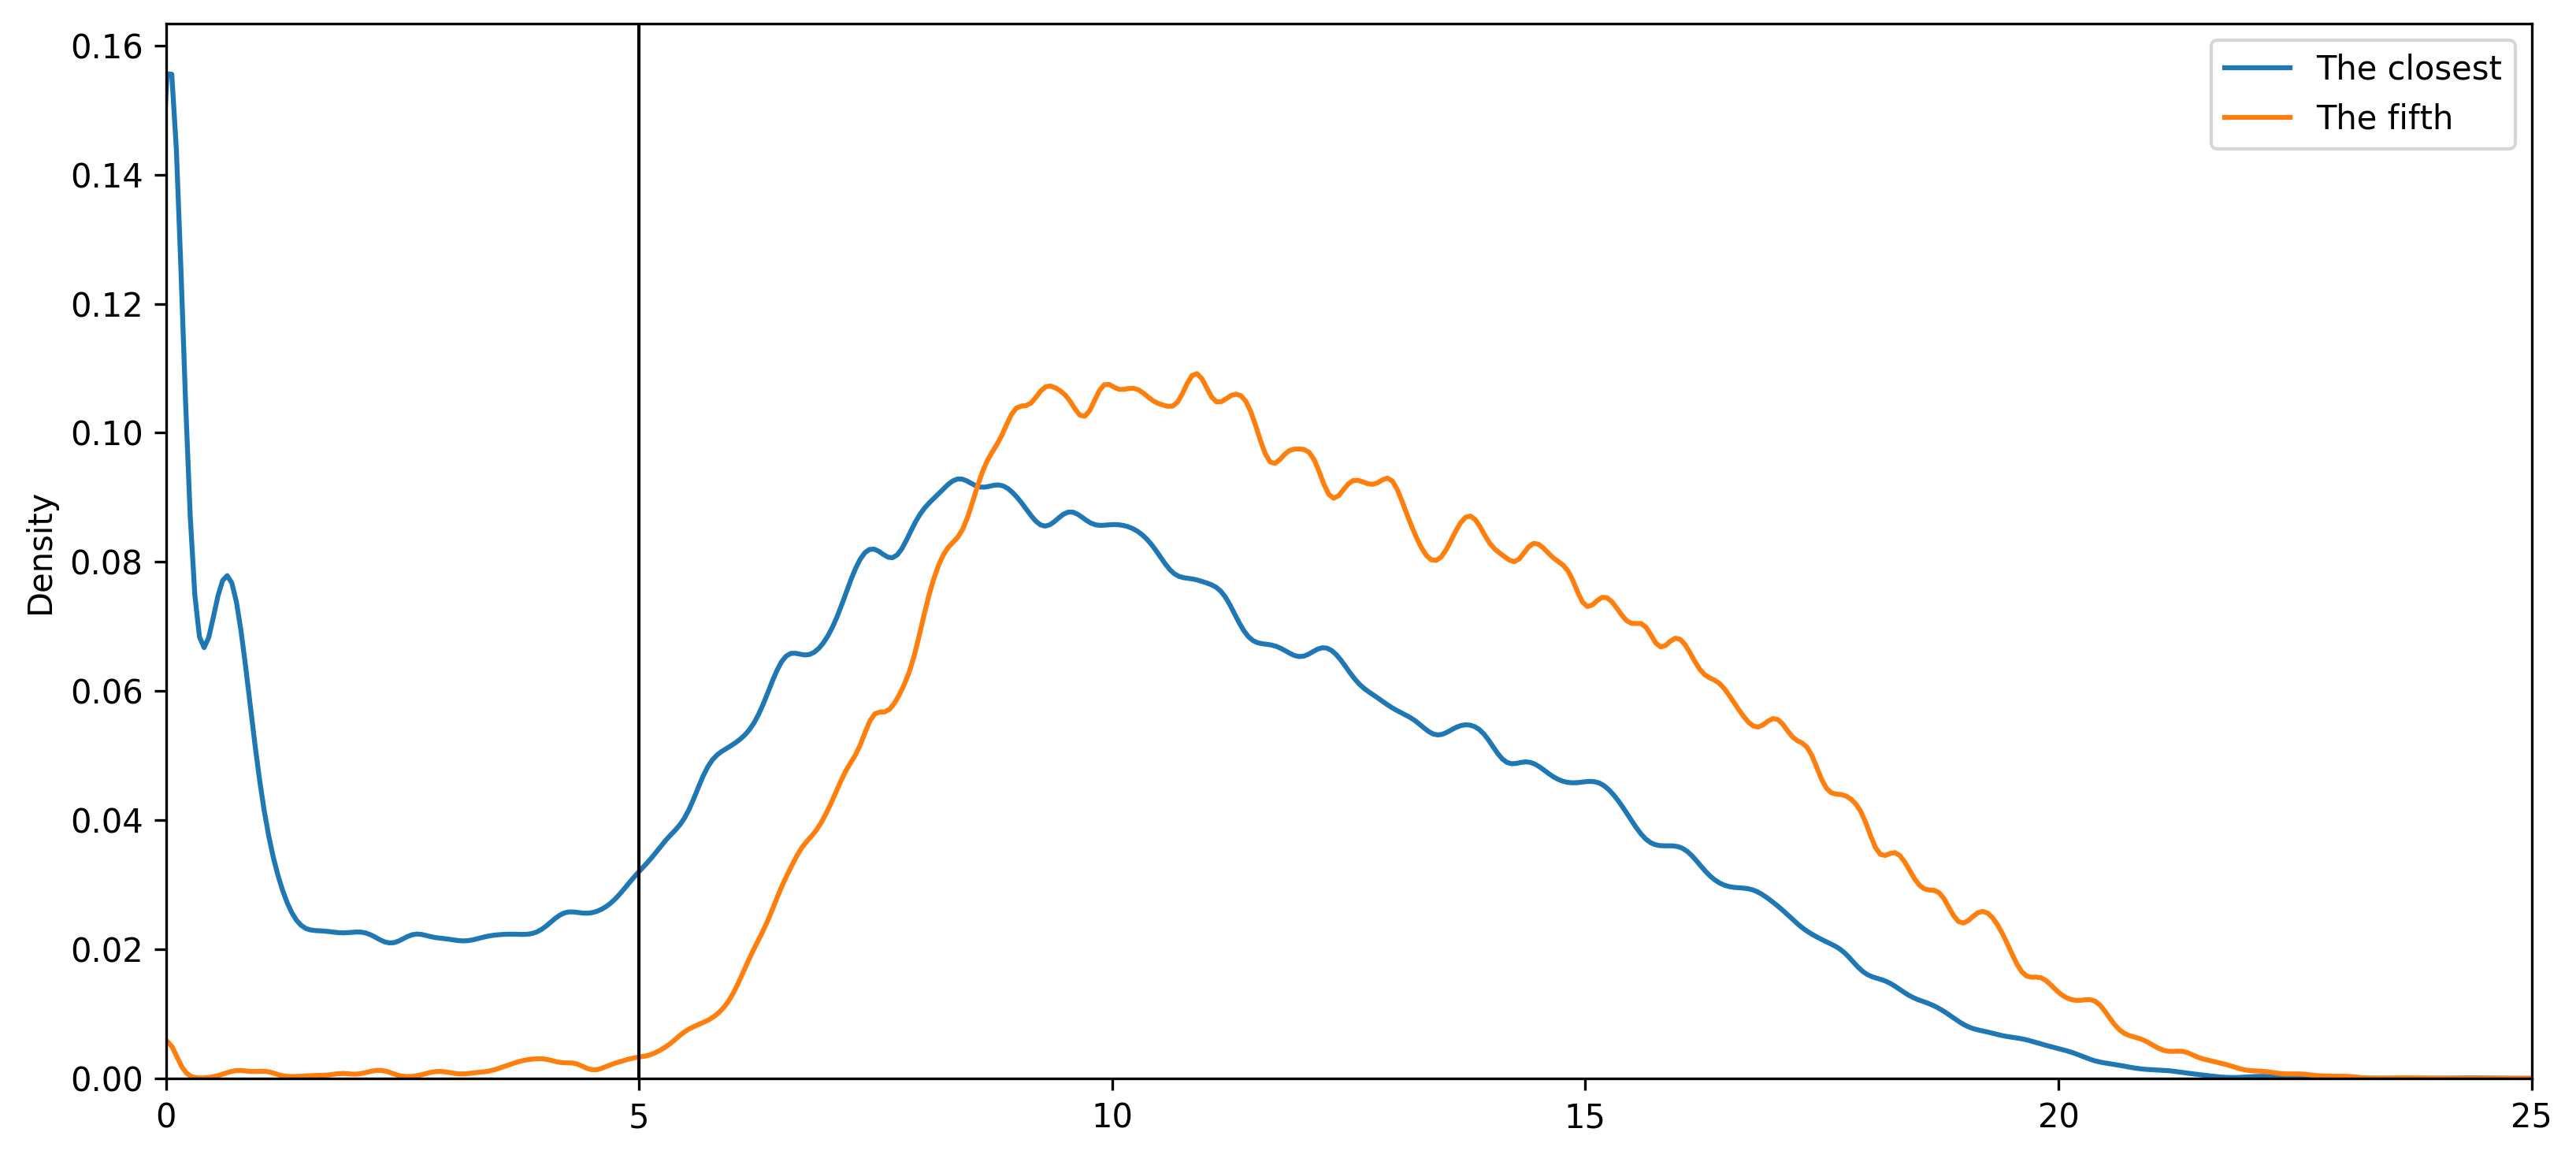

In [229]:
print(np.count_nonzero(distances[:, 0] < 5), np.count_nonzero(distances[:, 4] < 5))

fig = plt.figure(figsize=(11,5), dpi=300)
ax = pd.DataFrame(
    {"The closest": distances[:, 0], "The fifth": distances[:, 4]}
).plot.kde(bw_method=0.03, ax=fig.gca())
ax.set_xlim(0,25)
ax.set_ylim(bottom=0)
ax.axvline(5, lw=1, c="k")

plt.tight_layout()
fig.savefig("distance_kde.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

(50540, 28, 28, 6)


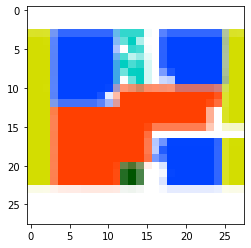

In [225]:
# flip ploorplans horizontly

print(fps_array.shape)
fps_flipped = np.flip(fps_array, 2)  # flip columns
fps_flipped_rgba = np.clip(
    np.array([1.0, 1.0, 1.0, 0.0]) + (np.array(fps_flipped) @ channel_to_rgba), 0, 1
)
fig = plt.figure()
ax = plt.imshow(fps_flipped_rgba[ids.index("9765_107A")])

In [226]:
Y = fps_flipped.reshape(50540, 4704)
distances_flipped, indices_flipped = neigh.kneighbors(Y)

In [227]:
print(np.count_nonzero(distances_flipped[:, 0] < 5), np.count_nonzero(distances_flipped[:, 4] < 5))


1233 14


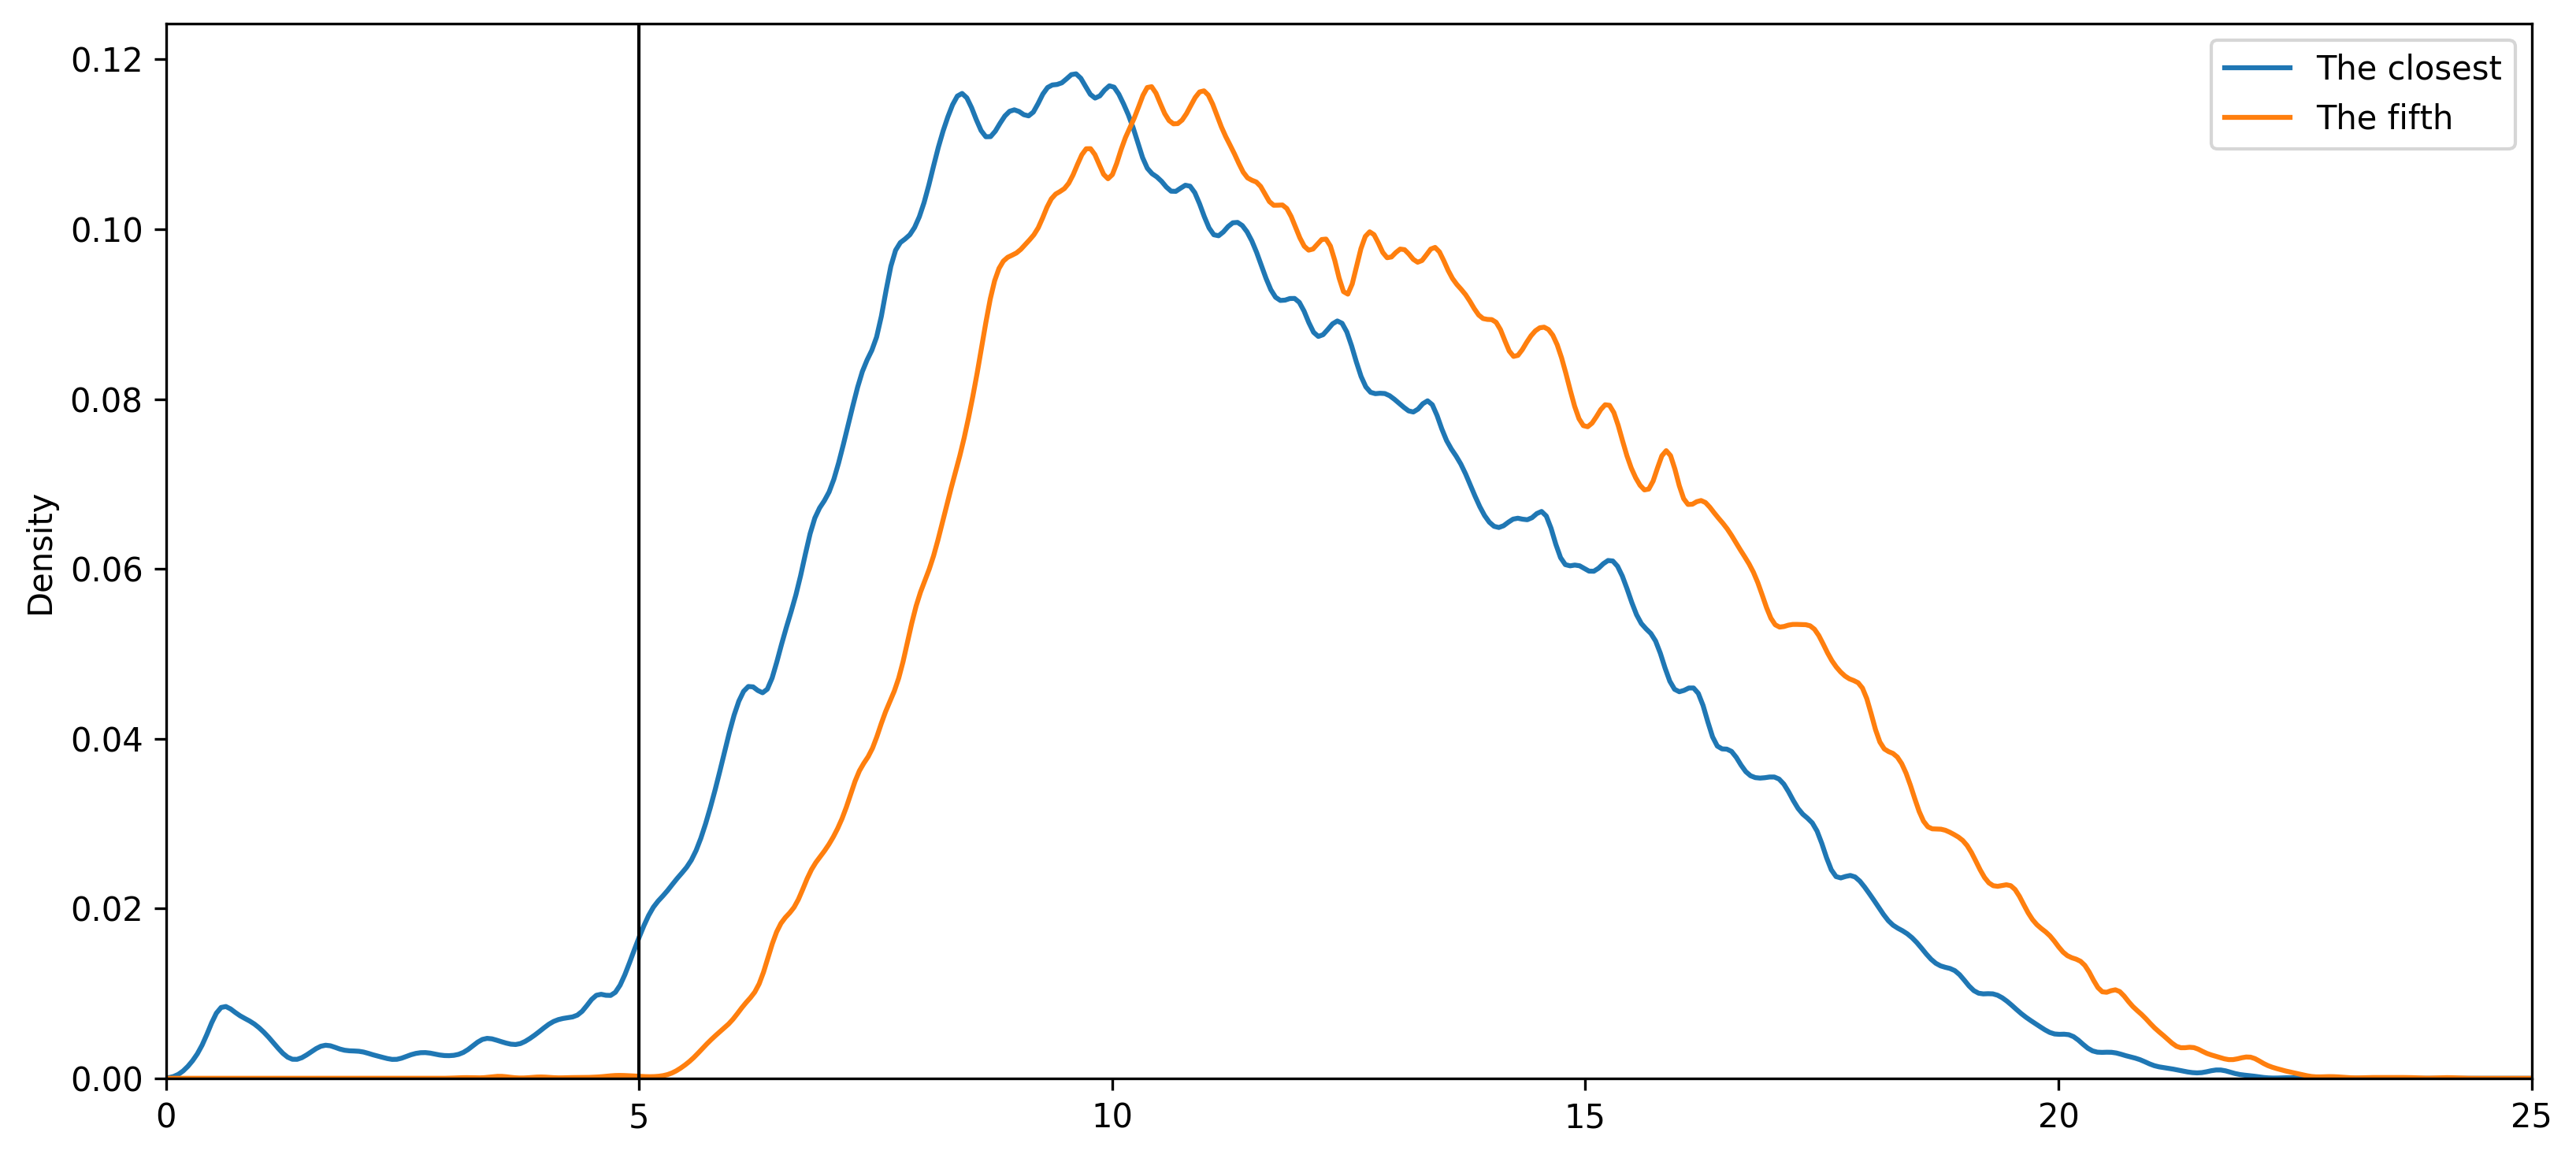

In [230]:
fig = plt.figure(figsize=(11,5), dpi=300)
ax = pd.DataFrame(
    {"The closest": distances_flipped[:, 0], "The fifth": distances_flipped[:, 4]}
).plot.kde(bw_method=0.03, ax=fig.gca())
ax.set_xlim(0,25)
ax.set_ylim(bottom=0)
ax.axvline(5, lw=1, c="k")

plt.tight_layout()
fig.savefig("distance_flipped.pdf", bbox_inches="tight", pad_inches=0)
plt.show()